# This a demo for Hamiltonian-Learning on a XXZ heisenberg chain

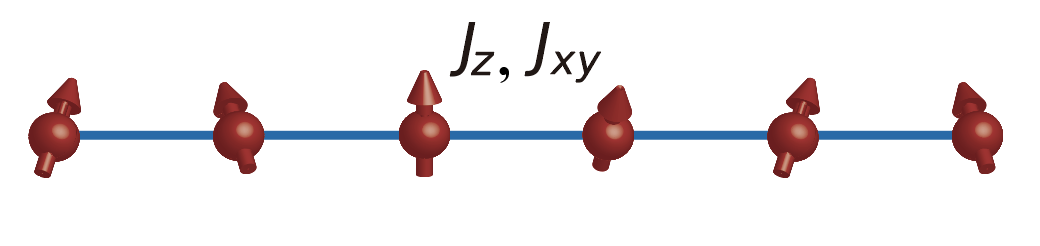
###  $$H = \sum_{\langle i,j \rangle} J_{xy} (S_i^{x} S_j^{x} + S_i^y S_j^y) 
+ J_z S_i^z S_j^z$$

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import cm
import parameters
import pandas as pd
from solver_ED import solver_ED
from SubFunc.Calcul_Loss import calcul_loss
from SubFunc.get_T_cut import get_T_cut
from adlib.ThObs import Th_obs
from SubFunc.CalSus_Num import calcul_chi_num
from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction

from scipy.interpolate import griddata

First look at our experiment data


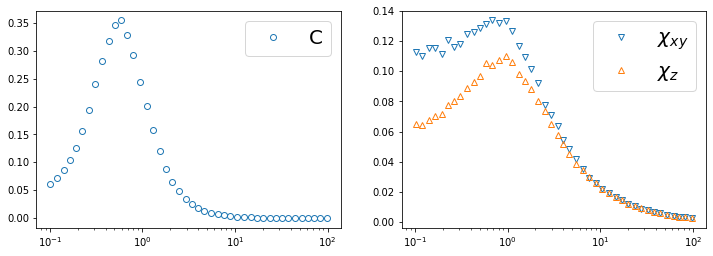

In [21]:
C = np.loadtxt('./Data/C_exp.csv', delimiter=',')
T = np.loadtxt('./Data/T_exp.csv', delimiter=',')
Chixy = np.loadtxt('./Data/Chixy_exp.csv', delimiter=',')
Chiz = np.loadtxt('./Data/Chiz_exp.csv', delimiter=',')



fig, [ax_c, ax_chi] = plt.subplots(1, 2, figsize=[12,4]) 
ax_c.semilogx(T, C, 'o', fillstyle='none', label='C')
ax_chi.semilogx(T, Chixy, 'v', fillstyle='none', label=r'$\chi_{xy}$')
ax_chi.semilogx(T, Chiz, '^', fillstyle='none',label=r'$\chi_{z}$')
ax_c.legend(fontsize=20)
ax_chi.legend(fontsize=20)
print('First look at our experiment data')

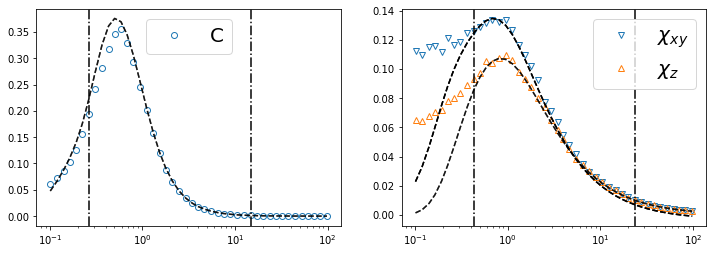

In [25]:
# this is how you solve the system by ED

# Jz = torch.tensor( 0.097179772, requires_grad=True)
# Jxy = torch.tensor(1.5237368651, requires_grad=True)

Jz = torch.tensor(1.5, requires_grad=True)
Jxy = torch.tensor(1., requires_grad=True)

# define the system
params = parameters.params()
params.get_Hamiltonian_params(Jz=Jz, Jxy=Jxy, hz=0, hx=0, d=2)
params.get_system_params(L=10, T=T)

# ED solver
solver = solver_ED(L=8)
obs = solver.forward(params=params)

#numerical calculation of xy-direction susceptibility
calcul_chi_num(obs, params, solver.solver_params, 0.05)

#for convenience
obs_real = Th_obs(params=params)
obs_real.T = torch.tensor(T)
obs_real.C = torch.tensor(C)
obs_real.Chi = torch.tensor(Chiz)
obs_real.Chi_paral = torch.tensor(Chixy)

#let's see how ED fit the experiment
fig.axes[0].semilogx(obs.T, obs.C.detach().numpy(), '--', color='black', label='ED', alpha=0.7)
fig.axes[1].semilogx(obs.T, obs.Chi.detach().numpy(), '--', color='black', label='ED', alpha=0.7)
fig.axes[1].semilogx(obs.T, obs.Chi_paral.detach().numpy(), '--', color='black', label='ED')
fig

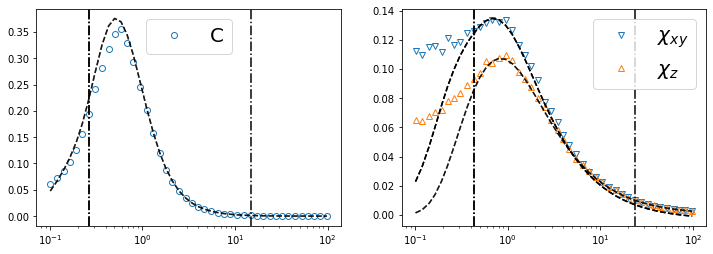

In [26]:
#Now we see it is curcial to first introduce a T_cut to choose the appropriate temperature interval for fitting
T_cut = get_T_cut(['C', 'Chi', 'Chi_paral'], obs_real, params, shift=-5)

fig.axes[0].axvline(obs_real.T[-T_cut['C']], ls='-.', color='black', label=r'$T_{cut}$')
fig.axes[1].axvline(obs_real.T[-T_cut['Chi']], ls='-.', color='black', label=r'$T_{cut}$')
fig

## Bayesian Optimization

Suppose the true parameter is unknown. We can define a loss function as follows

$$\mathcal{L} = \sum_{\alpha}\frac{1}{N_\alpha} \lambda_{\alpha}(\frac{O^{\rm expr}_\alpha-O^{\rm theor}_\alpha}{O^{\rm theor}_\alpha})^2$$ 

Bayesian Optimization (BO) is a powerful tool solving the following problem $$\arg \min_{\mathbf{x}} \mathcal{L}(\mathbf{x})$$

In [39]:
num_warmup = 10
nexp = 200
aqui_f = 'ei'

target_obs=['C', 'Chi', 'Chi_paral']

epsilon = 0.05
ksi = 0.02

#===========we define the "black box" function to optimize========#
def evaluate_parameter(Jxy, Jz):
    Jz = torch.tensor(Jz, requires_grad=True)
    Jxy = torch.tensor(Jxy, requires_grad=True)
    params = parameters.params()
    params.get_Hamiltonian_params(Jz=Jz, Jxy=Jxy, hz=0, hx=0, d=2)
    params.get_system_params(L=8, T=T)
    solver = solver_ED(L=8)
    obs = solver.forward(params=params)
    calcul_chi_num(obs, params, solver.solver_params, 0.05)
    Loss = calcul_loss(obs_real=obs_real, obs_iter=obs, target_obs=target_obs, T_cut=T_cut).detach().numpy()
    return -np.log10(Loss)

    
pbounds = {'Jxy': (-10., 10.), 'Jz': (-10., 10.)}
optimizer_bayesian = BayesianOptimization(
            f=evaluate_parameter,
            pbounds=pbounds,
            verbose=2,
            random_state=5)
utility = UtilityFunction(kind=aqui_f, kappa=2.5, xi=0.0)

y = np.zeros(nexp)
#Warm up
for i in range(num_warmup):
    next_point = {'Jxy': np.random.rand()*20 - 10 , 'Jz':np.random.rand()*20 - 10}
    target = evaluate_parameter(**next_point)
    y[i] = target
    optimizer_bayesian.register(params=next_point, target=target)
    

    print('Warming up.............{}/{}'.format(i+1, num_warmup))
    print('Found Loss {:.2e} at Jxy = {:.2f}, Jz = {:.2f}'.format(-target, next_point['Jxy'], next_point['Jz']))

#BO with e-greedy strategy
for _ in range(nexp - num_warmup):
    x = np.random.random()
    if x < 1 - epsilon:
        utility.xi = y[0:_+num_warmup].std() * ksi
        next_point = optimizer_bayesian.suggest(utility)
        target = evaluate_parameter(**next_point)
        y[_ + num_warmup] = target
        optimizer_bayesian.register(params=next_point, target=target)
        print('Greedy..............{}/{}_iter'.format(_ + 1 + num_warmup, nexp))
        print('Found Loss {:.2e} at Jxy = {:.2f}, Jz = {:.2f}'.format(target, next_point['Jxy'], next_point['Jz']))
    else:
        next_point = {'Jxy': np.random.rand()*20 - 10 , 'Jz':np.random.rand()*20 - 10}
        target = evaluate_parameter(**next_point)
        y[_ + num_warmup] = target
        optimizer_bayesian.register(params=next_point, target=target)
        print('Random..............{}/{}_iter'.format(_ + 1 + num_warmup, nexp))
        print('Found Loss {:.2e} at Jxy = {:.2f}, Jz = {:.2f}'.format(target, next_point['Jxy'], next_point['Jz']))



print("=======================COMPLETED=======================\n\n\n")
best = optimizer_bayesian.max
print("Best paramter find at Jxy = {:.2f}, Jz = {:.2f}, with loss = {:.2e}".
      format(best['params']['Jxy'], best['params']['Jz'], best['target']))


Warming up.............1/10
Found Loss 2.26e+00 at Jxy = 7.05, Jz = -7.56
Warming up.............2/10
Found Loss 2.61e+00 at Jxy = 7.02, Jz = -9.04
Warming up.............3/10
Found Loss 2.67e+00 at Jxy = -0.03, Jz = -8.48
Warming up.............4/10
Found Loss 2.67e+00 at Jxy = 0.12, Jz = -9.40
Warming up.............5/10
Found Loss 2.62e+00 at Jxy = -0.28, Jz = -4.85
Warming up.............6/10
Found Loss 2.47e+00 at Jxy = 0.68, Jz = -3.11
Warming up.............7/10
Found Loss 2.65e+00 at Jxy = -1.69, Jz = -6.79
Warming up.............8/10
Found Loss -7.47e-02 at Jxy = 1.93, Jz = 1.96
Warming up.............9/10
Found Loss 2.27e+00 at Jxy = -8.54, Jz = -6.68
Warming up.............10/10
Found Loss 6.32e-01 at Jxy = 6.58, Jz = 1.16
Greedy..............11/200_iter
Found Loss -4.44e-01 at Jxy = 2.50, Jz = 4.02
Greedy..............12/200_iter
Found Loss -3.41e-01 at Jxy = 3.24, Jz = 1.79
Greedy..............13/200_iter
Found Loss 1.45e-01 at Jxy = 0.29, Jz = 2.55
Greedy..............14/

Greedy..............107/200_iter
Found Loss -2.63e+00 at Jxy = -5.36, Jz = -8.10
Random..............108/200_iter
Found Loss -5.20e-01 at Jxy = 2.81, Jz = 4.52
Greedy..............109/200_iter
Found Loss -6.54e-01 at Jxy = 7.25, Jz = 0.97
Greedy..............110/200_iter
Found Loss 9.99e-01 at Jxy = 1.03, Jz = 1.84
Greedy..............111/200_iter
Found Loss 6.06e-01 at Jxy = 1.09, Jz = 1.96
Greedy..............112/200_iter
Found Loss -1.75e+00 at Jxy = -7.78, Jz = 0.29
Greedy..............113/200_iter
Found Loss 3.09e-01 at Jxy = 1.46, Jz = 0.88
Greedy..............114/200_iter
Found Loss 6.97e-01 at Jxy = 1.15, Jz = 0.92
Greedy..............115/200_iter
Found Loss 6.71e-01 at Jxy = 1.32, Jz = 1.77
Greedy..............116/200_iter
Found Loss 5.44e-01 at Jxy = 1.71, Jz = 0.65
Greedy..............117/200_iter
Found Loss 1.03e+00 at Jxy = 0.92, Jz = 1.54
Greedy..............118/200_iter
Found Loss -5.84e-01 at Jxy = 7.36, Jz = -1.12
Greedy..............119/200_iter
Found Loss 1.19e+00 at

In [38]:
'{:.2e}'.format(evaluate_parameter(1.0, 1.5))

'1.66e+00'

### Author's note: 
This demo is a proof-of-principle introduction to QMagen project. 

We plan to have a first release of this project in late-December.